In [1]:
import os
import pickle
import random
import math
import numpy as np
import sklearn.datasets 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from torch.optim.optimizer import Optimizer

torch.set_default_tensor_type(torch.FloatTensor)
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import torch.nn.functional as F


from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
#import palettable
mpl.style.use('default')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Classes for BinaryConnect (stochastic version of STE)

In [2]:
from torch.autograd import Function

class BinarizeF2(Function):
    @staticmethod
    def forward(cxt, input):
        sigma = torch.clamp((input+1)/2, 0, 1)
        output = 2 * torch.bernoulli(sigma) - 1
        return output

    @staticmethod
    def backward(cxt, grad_output):
        grad_input = grad_output.clone()
        return grad_input
# aliases
binarize2 = BinarizeF2.apply


class BinaryLinear2(nn.Linear):

    def forward(self, input):
        # binary_weight = binarize(self.weight)
        #if input.size(1) != 784:
        #    input.data = binarize(input.data)
        if not hasattr(self.weight, 'org'):
            self.weight.org = self.weight.data.clone()
        self.weight.data = binarize2(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org = self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out


    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv

#### Define a STE MLP and a full precision one

In [3]:
class MLP_STE_cvx_sto(nn.Module):
    """Multi-Layer Perceptron used for MNIST. No convolution layers.
       This model is the MLP architecture used in paper "An empirical study of Binary NN optimization".
    """
    def __init__(self, in_features, out_features):
        super(MLP_STE_cvx_sto, self).__init__()
        self.in_features = in_features

        self.fc1 = BinaryLinear2(in_features, out_features, bias=False)


    def forward(self, x):
        x = x.view(-1, self.in_features)
        x = self.fc1(x)

        return x  # if used NLL loss, the output should be changed to F.log_softmax(x,dim=1),


class MLP_cvx(nn.Module):
    """Multi-Layer Perceptron used for MNIST. No convolution layers.
       This model is the MLP architecture used in paper "An empirical study of Binary NN optimization".
    """
    def __init__(self, in_features, out_features):
        super(MLP_cvx, self).__init__()
        self.in_features = in_features

        self.fc1 = nn.Linear(in_features, out_features, bias=False)


    def forward(self, x):
        x = x.view(-1, self.in_features)
        x = self.fc1(x)

        return x  # if used NLL loss, the output should be changed to F.log_softmax(x,dim=1),
# this is the network used for synthetic data

#### Useful class

In [4]:
class BasicDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = X
        self.y = y
        self.landmarks_frame = X.size(0)
        self.transform = transform

    def __len__(self):
        return self.landmarks_frame

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx], self.y[idx]

## Function to train a full precision NN

In [21]:
def real_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP_cvx(d, 1)
    model = model.to(torch.device("cuda:1"))
    #model.fc1.weight.data = 0*model.fc1.weight.data.sign()

    optimizer = optim.SGD(model.parameters(), lr=lr_start)

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()

    for i in range(epochs):
        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            output = model.forward(Xbatch)
            loss = torch.sum(-((ybatch-1)*output.squeeze() - torch.log(1+torch.exp(-output.squeeze())))) / len(train_loader.sampler)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            L.append(loss.detach().cpu().numpy())

            
        model.eval()
        test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
                output = model(data)
                test_loss += torch.sum(-((target-1)*output.squeeze() - torch.log(1+torch.exp(-output.squeeze())))).item()  # sum up batch loss
                pred = output.sign() # get the index of the max log-probability
                total_correct += pred.eq(target.view_as(pred)).sum().item()
        list_test_loss.append(test_loss/len(test_loader.sampler))
        list_test_accuracy.append(total_correct / len(test_loader.sampler))

    ax.plot(L, zorder=3)

    return model.fc1.weight.data[0].detach().cpu().numpy(), L, list_test_loss, list_test_accuracy

# Function to train BinaryConnect

In [6]:
def sto_binaryconnect_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP_STE_cvx_sto(d, 1)
    model = model.to(torch.device("cuda:1"))
    #model.fc1.weight.data = 0*model.fc1.weight.data.sign()

    optimizer = optim.SGD(model.parameters(), lr=lr_start)

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()

    for i in range(epochs):
        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            output = model.forward(Xbatch)
            loss = torch.sum(-((ybatch-1)*output.squeeze() - torch.log(1+torch.exp(-output.squeeze())))) / len(train_loader.sampler)
            optimizer.zero_grad()
            loss.backward()
            for p in list(model.parameters()):
                if hasattr(p, 'org'):
                    p.data.copy_(p.org)
            optimizer.step()
            for p in list(model.parameters()):
                if hasattr(p, 'org'):
                    p.org.copy_(p.data.clamp_(-1, 1))
            L.append(loss.detach().cpu().numpy())

            
        model.eval()
        test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
                output = model(data)
                test_loss += torch.sum(-((target-1)*output.squeeze() - torch.log(1+torch.exp(-output.squeeze())))).item()  # sum up batch loss
                pred = output.sign() # get the index of the max log-probability
                total_correct += pred.eq(target.view_as(pred)).sum().item()
        list_test_loss.append(test_loss/len(test_loader.sampler))
        list_test_accuracy.append(total_correct / len(test_loader.sampler))

    ax.plot(L)

    return model.fc1.weight.data[0].detach().cpu().numpy(), L, list_test_loss, list_test_accuracy

# Function to train AskewSGD

In [19]:
def ours_net(ax, epsilon, alpha, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP_cvx(d, 1)
    model = model.to(torch.device("cuda:1"))
    #model.fc1.weight.data = 0*model.fc1.weight.data.sign()

    optimizer = optim.SGD(model.parameters(), lr=lr_start)

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()

    for i in range(epochs):
        if i < 50:
            epsilon =1.
        else:
            epsilon=.96**(i-50)
            #print(epsilon)
        #epsilon = .96**i
        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            output = model.forward(Xbatch)
            loss = torch.sum(-((ybatch-1)*output.squeeze() - torch.log(1+torch.exp(-output.squeeze())))) / len(train_loader.sampler)
            optimizer.zero_grad()
            loss.backward()
            for param_group in optimizer.param_groups:
                for idx, p in enumerate(param_group['params']):
                    constr = epsilon-(p.data**2-1)**2
                    Kx = alpha * (epsilon-(p.data**2-1)**2) / (4 * p.data * (p.data**2-1))
                    direct_grad = torch.logical_or(torch.logical_or(p.data==0, constr >= 0), (-p.grad.data)*Kx > Kx**2)
                    p.grad.data[direct_grad] = p.grad.data[direct_grad]
                    p.grad.data[~direct_grad] = -Kx[~direct_grad]
            optimizer.step()
            for p in list(model.parameters()):
                p.data.clamp_(-1, 1)
            L.append(loss.detach().cpu().numpy())

            
        model.eval()
        test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
                output = model(data)
                test_loss += torch.sum(-((target-1)*output.squeeze() - torch.log(1+torch.exp(-output.squeeze())))).item()  # sum up batch loss
                pred = output.sign() # get the index of the max log-probability
                total_correct += pred.eq(target.view_as(pred)).sum().item()
        list_test_loss.append(test_loss/len(test_loader.sampler))
        list_test_accuracy.append(total_correct / len(test_loader.sampler))

    #ax.plot(L, linewidth=7.0, zorder=3)
    ax.plot(L, linewidth=7.)

    return model.fc1.weight.data[0].detach().cpu().numpy(), L, list_test_loss, list_test_accuracy

## Classes imported from AdaSTE's

In [13]:
class FenBPOpt(Optimizer):

    def __init__(self, model, train_set_size, lr=1e-4, betas=0.0, delta=1e-6, eta=0.9999, lamda_init=10, lamda_std=0, reweight=1, use_STE=False, fenbp_alpha = 0.01, fenbp_beta = 0.01):
        if train_set_size < 1:
            raise ValueError("Invalid number of datapoints: {}".format(train_set_size))

        defaults=dict(lr=lr, train_set_size=train_set_size, beta=betas)
        super(FenBPOpt, self).__init__(model.parameters(), defaults)

        self.train_modules = []
        self.set_train_modules(model)

        defaults = self.defaults
        parameters = self.param_groups[0]['params']
        self.param_groups[0]['lr'] = lr

        device = parameters[0].device

        p = parameters_to_vector(self.param_groups[0]['params'])

        mixtures_coeff = torch.randint_like(p,2)
        self.state['lamda'] =  mixtures_coeff * (lamda_init + np.sqrt(lamda_std)* torch.randn_like(p)) + (1-mixtures_coeff) * (-lamda_init + np.sqrt(lamda_std) * torch.randn_like(p))#  torch.log(1+p_value) - torch.log(1-p_value)  #torch.randn_like(p) # 100*torch.randn_like(p) # math.sqrt(train_set_size)*torch.randn_like(p)  #such initialization is empirically good, others are OK of course
        #self.state['lamda'] =  torch.zeros_like(p)
        #self.state['lamda'] = p.detach()
        
        #Momentum term
        self.state['momentum'] = torch.zeros_like(p, device=device) # momentum

        # step initilization
        self.state['step'] = 0
        self.state['reweight'] = reweight
        self.state['delta']=delta
        self.state['eta']=eta
        self.state['use_STE']=use_STE

        self.alpha = fenbp_alpha
        self.beta = fenbp_beta

    def set_train_modules(self, module):
        if len(list(module.children())) == 0:
            if len(list(module.parameters())) != 0:
                self.train_modules.append(module)
        else:
            for child in list(module.children()):
                self.set_train_modules(child)

    def get_grad(self, closure, theta, delta, eta, straight_through=False):
        parameters = self.param_groups[0]['params']

        #Annealing parameter
        beta = self.beta
        alpha = self.alpha

        # y = theta
        
        # Compute w*
        if straight_through:
            w_vector = torch.sign(theta)
        else:
            #print('insidehardtanh=', (theta + beta * (1 + alpha)*theta.sign())/(1 + beta))
            w_vector = F.hardtanh((theta + beta * (1 + alpha)*theta.sign())/(1 + beta), 
                    min_val=-1.0, max_val=1.0)

        # Pass to the model 
        vector_to_parameters(w_vector, parameters)
        
        #print('w_vector', w_vector)
        
        # Get loss and predictions
        loss, preds = closure()

        linear_grad = torch.autograd.grad(loss, parameters)  # compute the gradidents
        grad = parameters_to_vector(linear_grad).detach()
        
        #print('gradbefore', grad)

        # Use sign to evaluate
        vector_to_parameters(torch.sign(theta), parameters)
        loss, preds = closure()

        if straight_through:
            return loss, preds, grad

        # Scale the gradients
        scale = torch.ones_like(theta)

        mask_pos_grad = grad > 1e-3
        mask_neg_grad = grad < -1e-3

        if (beta * alpha < 1):
            scale *= 1/(1 + beta)
            mask_pos_x = theta > max(1e-6, 1 - beta * alpha)
            mask_neg_x = theta < min(-1e-6,-1 + beta * alpha)

            mask_pos_mid_x  = (1e-6 < theta) & (theta < 1 - beta * alpha)
            mask_neg_mid_x = (-1 + beta * alpha < theta ) & ( theta  < -1e-6)

            mask = (mask_pos_x & mask_neg_grad) | (mask_neg_x & mask_pos_grad)
            scale[mask] = 0.0
            
            mask = (mask_neg_grad & mask_neg_x) | (mask_pos_grad & mask_pos_x)
            scale[mask] = torch.clamp( ((1 + 2*beta + beta*alpha)/(1 + beta))* 1./theta[mask].abs(), min=0, max = 0.5 )

            mask = (mask_neg_grad & mask_neg_mid_x) | (mask_pos_grad & mask_pos_mid_x)
            scale[mask] = torch.clamp( ((2*beta*(1+alpha) - theta[mask])/(1 + beta))*1./theta[mask].abs(), min=0, max = 0.5)

        else:
            mask_pos_x = theta > 1e-3
            mask_neg_x = theta < -1e-3

            mask = (mask_pos_x & mask_pos_grad) | (mask_neg_x & mask_neg_grad)
            scale[mask] = torch.clamp(1./theta[mask].abs(), min=0, max = 0.5)

            mask = (mask_pos_x & mask_neg_grad) | (mask_neg_x & mask_pos_grad)
            scale[mask] = 0.0

        grad *= scale
        #print('grad', grad)
        return loss, preds, grad

    def step(self, closure):
        """Performs a single optimization step.
        Arguments:
            closure (callable): A closure that reevaluates the model
                and returns the loss without doing the backward pass
        """
        if closure is None:
            raise RuntimeError(
                'For now, BayesBiNN only supports that the model/loss can be reevaluated inside the step function')

        loss_list = []
        pred_list = []
        self.state['step'] += 1

        defaults = self.defaults
        # We only support a single parameter group.
        parameters = self.param_groups[0]['params']
        lr = self.param_groups[0]['lr']
        momentum_beta = defaults['beta']
        momentum = self.state['momentum']

        # mu = self.state['mu']
        lamda = self.state['lamda']
        reweight = self.state['reweight']

        grad_hat = torch.zeros_like(lamda)

        delta = self.state['delta']
        eta = self.state['eta']
        
        # Obtain gradients
        loss, pred, gr = self.get_grad(closure, lamda, delta=delta, eta = self.state['eta'], straight_through=self.state['use_STE'] )

        loss_list.append(loss)
        pred_list.append(pred)

        #grad_hat = gr
        grad_hat = defaults['train_set_size'] * gr
        #grad_hat = grad_hat.mul(defaults['train_set_size'])

        # Add momentum
        self.state['momentum'] = momentum_beta * self.state['momentum'] + (1-momentum_beta)*(grad_hat + reweight*(self.state['lamda'] ))

        # Get the mean loss over the number of samples
        loss = torch.mean(torch.stack(loss_list))

        # Bias correction of momentum as adam
        bias_correction1 = 1 - momentum_beta ** self.state['step']

        # Update lamda vector
        self.state['lamda'] = self.state['lamda'] - self.param_groups[0]['lr'] * self.state['momentum']/bias_correction1
        #print("self.state['lamda']", self.state['lamda'])

        return loss, pred_list

# Function to train AdaSTE

In [14]:
def adaste(ax, epsilon, alpha, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP_cvx(d, 1)
    model = model.to(torch.device("cuda:1"))
    
    effective_trainsize = len(train_loader.sampler)
    optimizer=FenBPOpt(model,train_set_size=effective_trainsize, 
                delta = 1e-6,
                lr = lr_start,
                use_STE = False,
                betas = .9,
                fenbp_alpha = 0.01,
                fenbp_beta = 100.
                )

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()

    for i in range(epochs):

        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            def closure():
                optimizer.zero_grad()
                output = model.forward(Xbatch)
                loss = torch.sum(-((ybatch-1)*output.squeeze() - torch.log(1+torch.exp(-output.squeeze())))) / len(train_loader.sampler)
                return loss, output

            loss, output = optimizer.step(closure)

            L.append(loss.detach().cpu().numpy())


    ax.plot(L)

    return model.fc1.weight.data[0].detach().cpu().numpy(), L, list_test_loss, list_test_accuracy

#### Helper for figure

In [15]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

# Train several methods with a batch of size 100

decay!!!
decay!!!
decay!!!
decay!!!


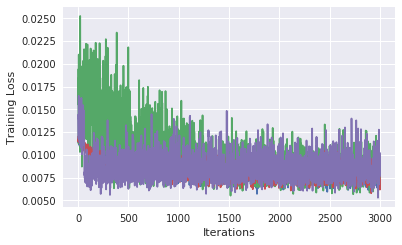

In [11]:
n_train=6000
n=n_train+1000
d=10
lr_start=2.
lr_decay_epochs = [30, 60]
lr_decay=.5
epochs=50
bs=100

w_star = 1. * ((torch.rand(d)-.5).sign())
#w_star = torch.tensor([1., 1.])
#w_star = torch.tensor([3., -0.7])

X = 2*(torch.rand((n,d)) - .5)

y = torch.bernoulli(1 / (1 + torch.exp(-torch.mv(X, w_star))))

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]
train_dataset = BasicDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataset = BasicDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=n-n_train, shuffle=False)

# Using seaborn's style
plt.style.use('seaborn')
width = 430
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
#ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'Iterations')
ax.set_ylabel(r'Training Loss')

theta_real, train_loss_real, test_loss_real, test_accuracy_real =  real_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_bc_sto, train_loss_bc_sto, test_loss_bc_sto, test_accuracy_bc_sto =  sto_binaryconnect_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_oursnet, train_loss_oursnet, test_loss_oursnet, test_accuracy_oursnet =  ours_net(ax, 1., .1, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_adaste, train_loss_adaste, test_loss_adaste, test_accuracy_adaste =  adaste(ax, 1., .1, d, epochs, lr_start/100, lr_decay_epochs, lr_decay, train_loader, test_loader)

# Save and remove excess whitespace
fig.savefig('training_loss_logisticregression_bs100.pdf', format='pdf', bbox_inches='tight')

In [12]:
theta_adaste

array([-1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1.], dtype=float32)

# Train several methods with a batch of size 100
#### (slightly pertub the optimal point from vertices by a factor $0.8$)

decay!!!
decay!!!
decay!!!
decay!!!


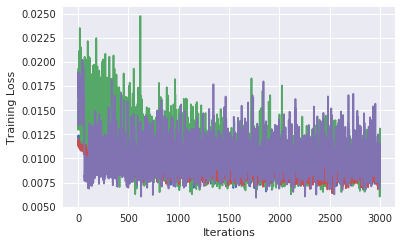

In [69]:
n_train=6000
n=n_train+1000
d=10
lr_start=2.
lr_decay_epochs = [30, 60]
lr_decay=.5
epochs=50
bs=100

w_star = .8 * ((torch.rand(d)-.5).sign())
#w_star = torch.tensor([1., 1.])
#w_star = torch.tensor([3., -0.7])

X = 2*(torch.rand((n,d)) - .5)

y = torch.bernoulli(1 / (1 + torch.exp(-torch.mv(X, w_star))))

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]
train_dataset = BasicDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataset = BasicDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=n-n_train, shuffle=False)

# Using seaborn's style
plt.style.use('seaborn')
width = 430
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
#ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'Iterations')
ax.set_ylabel(r'Training Loss')

theta_real, train_loss_real, test_loss_real, test_accuracy_real =  real_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_bc_sto, train_loss_bc_sto, test_loss_bc_sto, test_accuracy_bc_sto =  sto_binaryconnect_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
#theta_bc, train_loss_bc, test_loss_bc, test_accuracy_bc =  binaryconnect_net(d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
#theta_boolnet, train_loss_boolnet, test_loss_boolnet, test_accuracy_boolnet =  bool_net(d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_oursnet, train_loss_oursnet, test_loss_oursnet, test_accuracy_oursnet =  ours_net(ax, 1., .1, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_adaste, train_loss_adaste, test_loss_adaste, test_accuracy_adaste =  adaste(ax, 1., .1, d, epochs, lr_start/100, lr_decay_epochs, lr_decay, train_loader, test_loader)

# Save and remove excess whitespace
#fig.savefig('training_loss_logisticregression2.pdf', format='pdf', bbox_inches='tight')

# Train several methods with a batch of size 1000

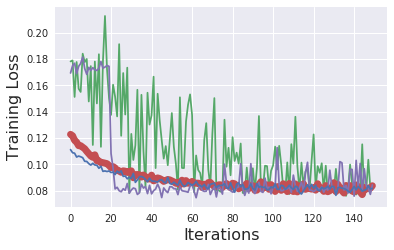

In [27]:
n_train=6000
n=n_train+1000
d=10
lr_start=2.
lr_decay_epochs = [30, 60]
lr_decay=.5
epochs=25
bs=1000

w_star = 1. * ((torch.rand(d)-.5).sign())
#w_star = torch.tensor([1., 1.])
#w_star = torch.tensor([3., -0.7])

X = 2*(torch.rand((n,d)) - .5)

y = torch.bernoulli(1 / (1 + torch.exp(-torch.mv(X, w_star))))

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]
train_dataset = BasicDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataset = BasicDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=n-n_train, shuffle=False)

# Using seaborn's style
plt.style.use('seaborn')
width = 430
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
#ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'Iterations', fontsize = 16)
ax.set_ylabel(r'Training Loss', fontsize = 16)

theta_real, train_loss_real, test_loss_real, test_accuracy_real =  real_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_bc_sto, train_loss_bc_sto, test_loss_bc_sto, test_accuracy_bc_sto =  sto_binaryconnect_net(ax, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
#theta_bc, train_loss_bc, test_loss_bc, test_accuracy_bc =  binaryconnect_net(d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
#theta_boolnet, train_loss_boolnet, test_loss_boolnet, test_accuracy_boolnet =  bool_net(d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_oursnet, train_loss_oursnet, test_loss_oursnet, test_accuracy_oursnet =  ours_net(ax, 1., .1, d, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
theta_adaste, train_loss_adaste, test_loss_adaste, test_accuracy_adaste =  adaste(ax, 1., .1, d, epochs, lr_start/100, lr_decay_epochs, lr_decay, train_loader, test_loader)

# Save and remove excess whitespace
fig.savefig('training_loss_logisticregression_bs1000_v2.pdf', format='pdf', bbox_inches='tight')